Index(['scandir_id', 'site', 'gender', 'age', 'handedness', 'dx',
       'secondary_dx', 'adhd_measure', 'adhd_index', 'inattentive',
       'hyper/impulsive', 'iq_measure', 'verbal_iq', 'performance_iq',
       'full2_iq', 'full4_iq', 'med_status', 'qc_rest_1', 'qc_rest_2',
       'qc_rest_3', 'qc_rest_4', 'qc_anatomical_1', 'qc_anatomical_2', 'id'],
      dtype='object')
Total count of unknown medication status: 74
Count of ADHD diagnosis with unknown medication status: 71
Number of -999 values in 'adhd_index': 19
'secondary_dx' column values:
 0               NaN
1               NaN
2               NaN
3     Simple phobia
4               NaN
          ...      
46              ODD
47              NaN
48              ODD
49              NaN
50              NaN
Name: secondary_dx, Length: 519, dtype: object
Maximum 'age': 17.96
Minimum 'age': 7.17
Maximum 'full4_iq': 144.0
Minimum 'full4_iq': 73.0
0     0
1     0
2     0
3     1
4     0
     ..
46    1
47    0
48    1
49    0
50    0


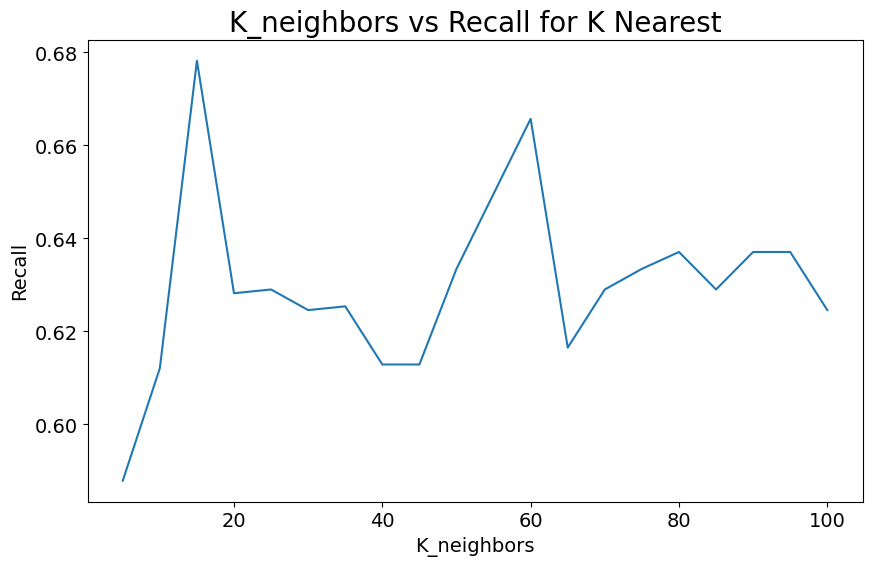

Random Forest Classifier
Best n_estimators: 10
Best recall: 0.7995967741935484


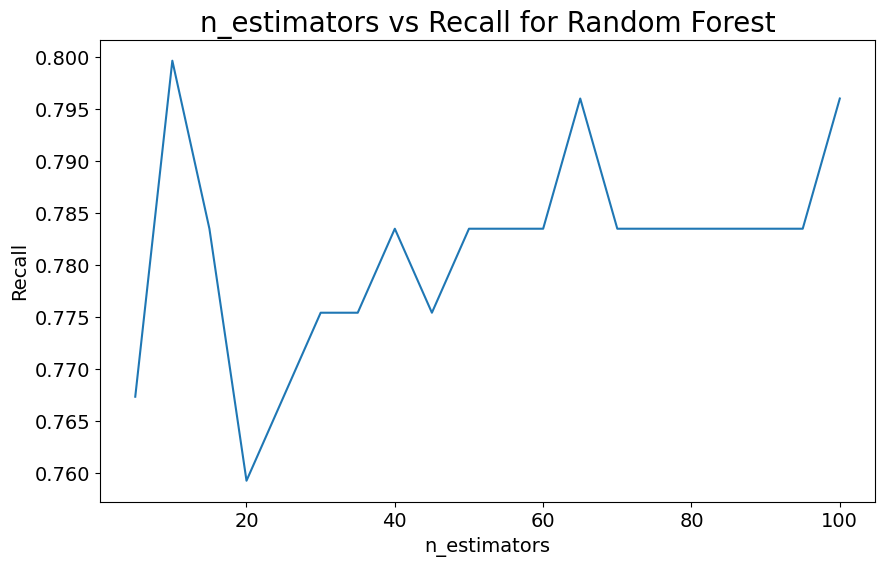

Gradient Boosting Classifier
Best n_estimators: 25
Best recall: 0.8149193548387097


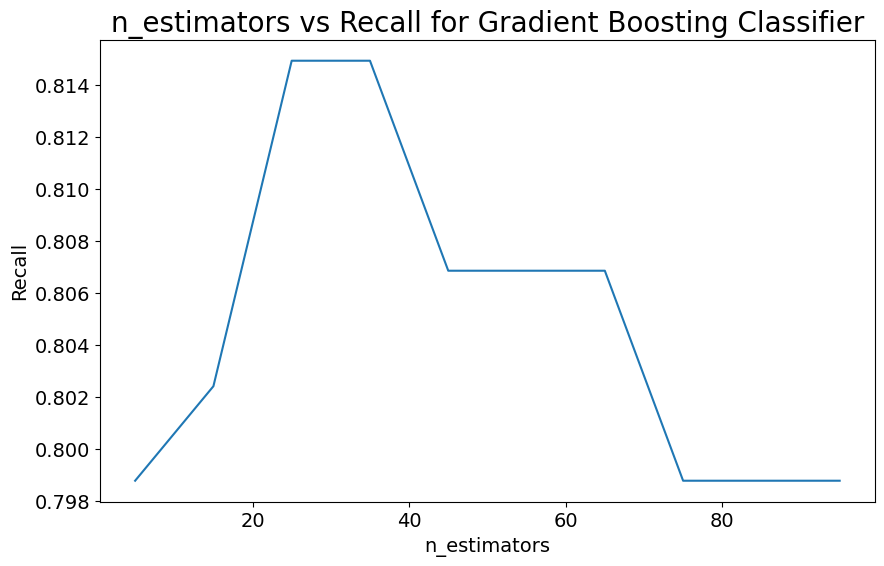

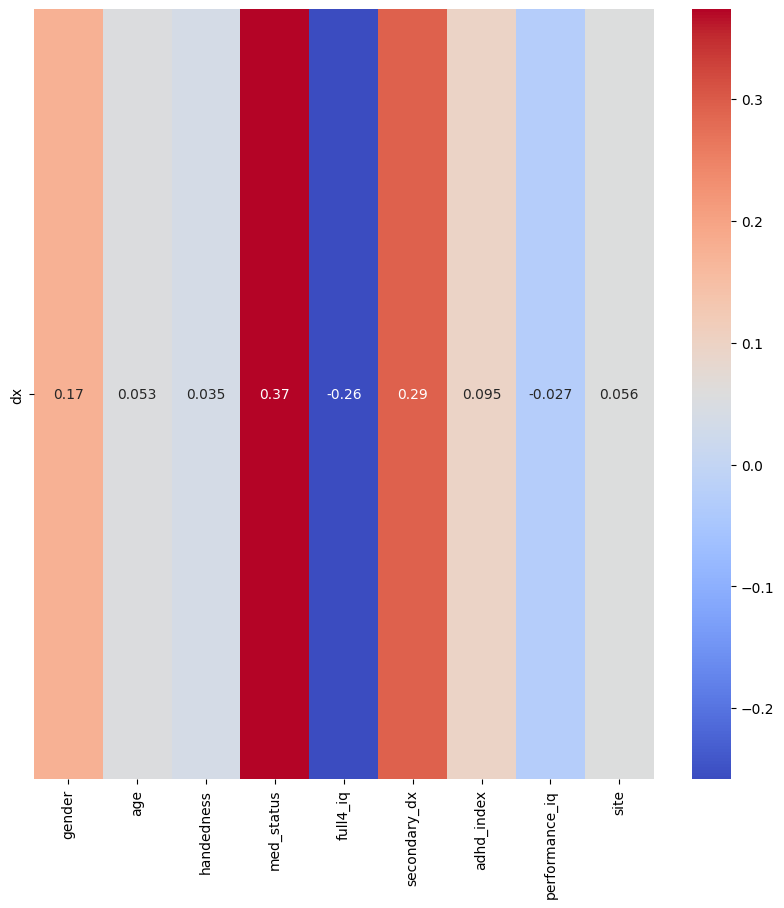

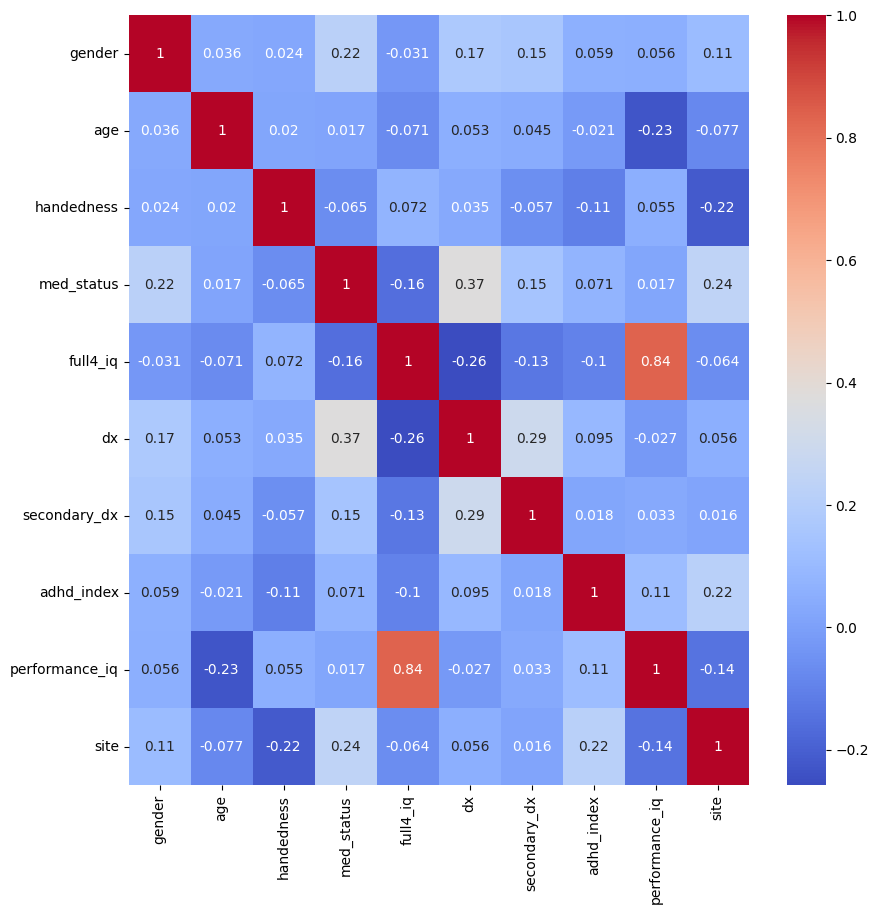

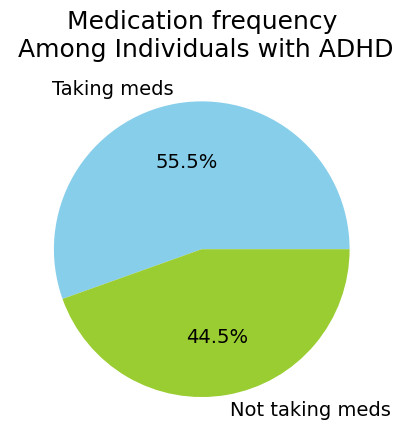

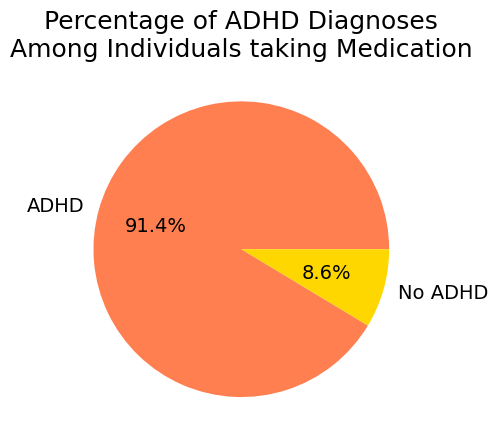

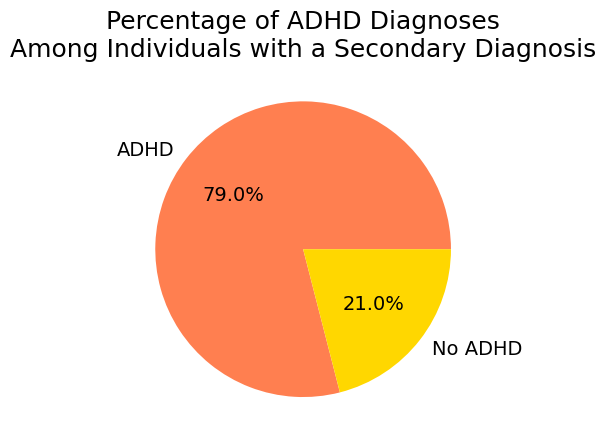

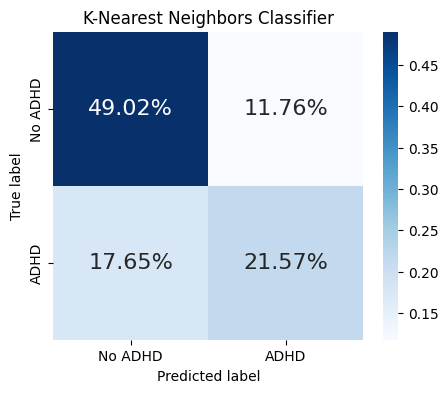

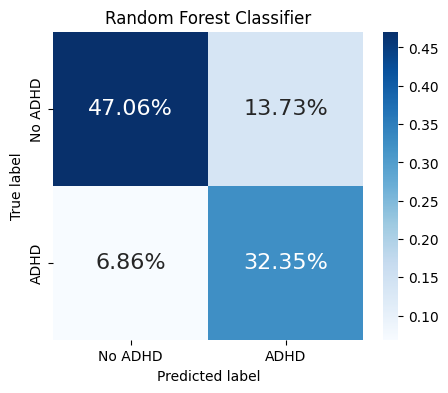

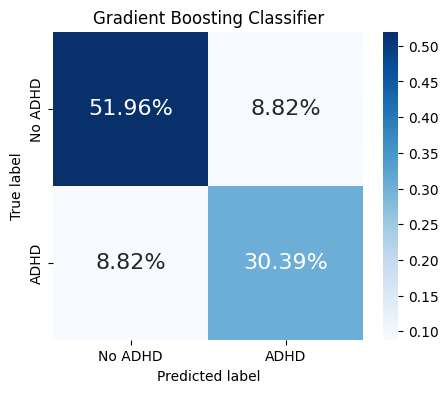

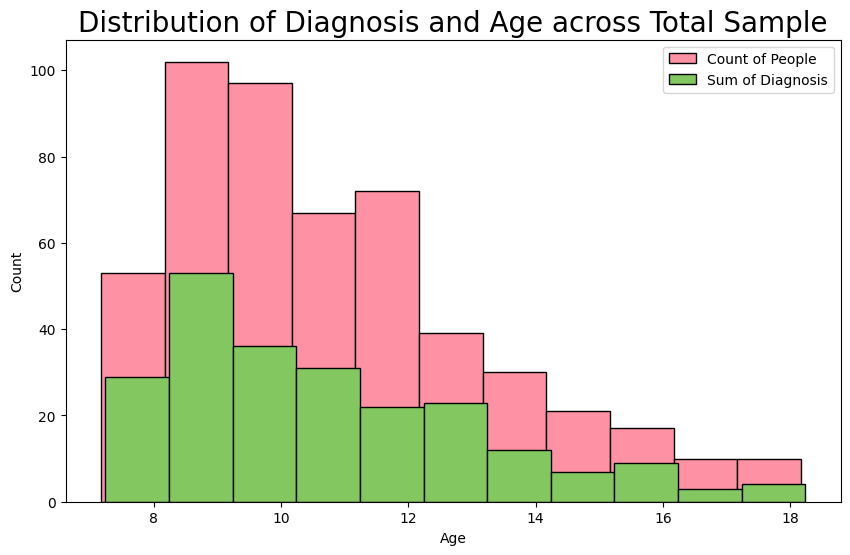

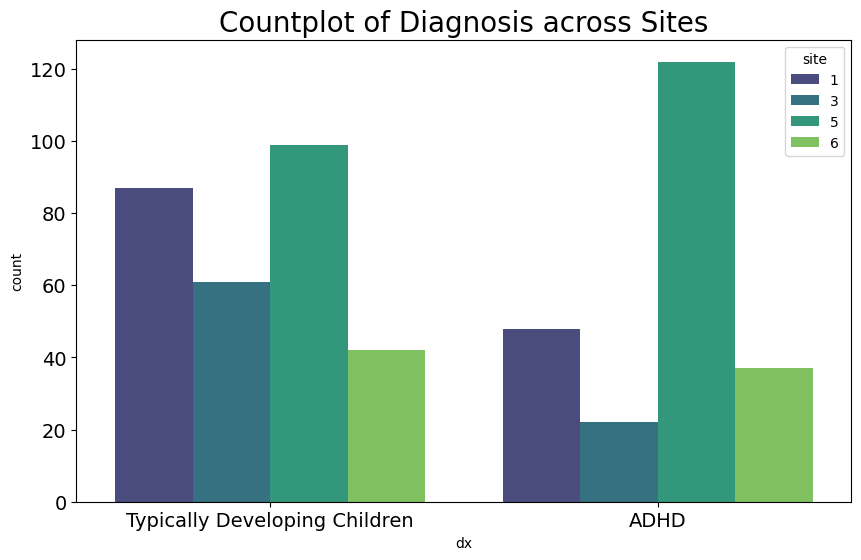

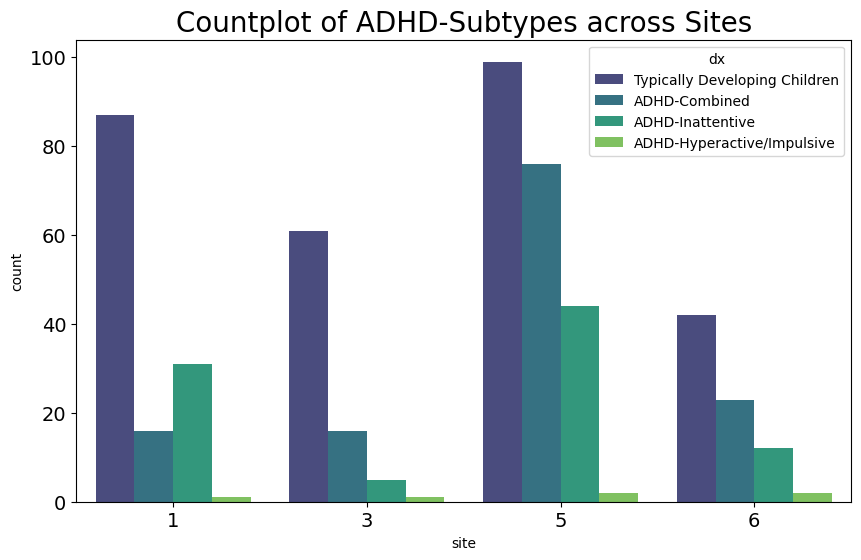

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Union, Tuple
from pandas import DataFrame, Series

# Function to load data
def load_data(path_to_file_name: str, list_of_file_names: List[str]) -> List[DataFrame]:
    """
    Load data from csv files into pandas DataFrames.

    :param path_to_file_name: The path to the directory containing the csv files.
    :param list_of_file_names: A list of csv file names (without the .csv extension).
    :return: A list of pandas DataFrames.
    """
    df_list = [pd.read_csv(f'{path_to_file_name}{file_name}.csv') for file_name in list_of_file_names]
    return df_list

def preprocess_data(df_list: List[DataFrame], required_columns: List[str]) -> DataFrame:
    """
    Preprocess the dataframes by merging them, renaming columns, and selecting required columns.

    :param df_list: A list of pandas DataFrames.
    :param required_columns: A list of column names to select.
    :return: A preprocessed pandas DataFrame.
    """
    merged_df = pd.concat(df_list)
    merged_df.columns = merged_df.columns.str.lower()
    merged_df.columns = merged_df.columns.str.strip()
    merged_df.columns = merged_df.columns.str.replace(' ', '_')
    print(merged_df.columns)
    merged_df = merged_df[required_columns]
    return merged_df

def clean_data(merged_df: DataFrame) -> DataFrame:
    """
    Clean the merged DataFrame by handling missing values and outliers.

    :param merged_df: The merged DataFrame to clean.
    :return: The cleaned DataFrame.
    """
    # Remove rows with NaN gender
    merged_df = merged_df[merged_df['gender'].notna()]

    med_status_unknown = merged_df[merged_df['med_status'] == -999]
    total_unknown_med_status = len(med_status_unknown)
    adhd_with_unknown_med_status = med_status_unknown[med_status_unknown['dx'].isin([1, 2, 3])]
    total_adhd_with_unknown_med_status = len(adhd_with_unknown_med_status)

    print("Total count of unknown medication status:", total_unknown_med_status)
    print("Count of ADHD diagnosis with unknown medication status:", total_adhd_with_unknown_med_status)

    # 96% of people that had unknown medication status were diagnosed with ADHD
    merged_df['med_status'] = merged_df['med_status'].replace(-999, 2)

    # Print the number of rows where 'adhd_index' is -999
    print("Number of -999 values in 'adhd_index':", (merged_df['adhd_index'] == -999).sum())
    print("'secondary_dx' column values:\n", merged_df['secondary_dx'])


    merged_df['secondary_dx'] = merged_df['secondary_dx'].apply(lambda x: 1 if isinstance(x, str) else 0)
    # Replace -999 with NaN in 'full2_iq' and 'full4_iq' columns where appropriate
    merged_df.loc[(merged_df['full2_iq'] == -999) & (merged_df['full4_iq'] != -999), 'full2_iq'] = np.nan
    merged_df.loc[(merged_df['full4_iq'] == -999) & (merged_df['full2_iq'] != -999), 'full4_iq'] = np.nan
    merged_df.loc[(merged_df['full4_iq'].isna()) & (merged_df['full2_iq'] == -999), 'full2_iq'] = np.nan
    merged_df.loc[(merged_df['full2_iq'].isna()) & (merged_df['full4_iq'] == -999), 'full4_iq'] = np.nan
    # Remove rows where 'handedness' is 'L'
    merged_df = merged_df[merged_df['handedness'] != 'L']

    # Convert 'handedness' to float and binarize it
    merged_df['handedness'] = merged_df['handedness'].astype(float)
    merged_df['handedness'] = merged_df['handedness'].apply(lambda x: 0 if x < 0.5 else 1)

    # Drop 'full2_iq' column
    merged_df = merged_df.drop('full2_iq', axis=1)

    print("Maximum 'age':", max(merged_df['age']))
    print("Minimum 'age':", min(merged_df['age']))
    print("Maximum 'full4_iq':", max(merged_df['full4_iq']))
    print("Minimum 'full4_iq':", min(merged_df['full4_iq']))

    return merged_df

def find_best_n_estimators_k_nearest(df: DataFrame, start: int = 5, end: int = 101, step: int = 5, columns_for_prediction_X : List[str] = ['gender', 'age', 'handedness', 'med_status', 'full4_iq']) -> int:
    """
    Find the optimal number of neighbors for a K-Nearest Neighbors classifier.

    :param merged_df: The merged DataFrame to use for prediction.
    :param start: The starting number of neighbors.
    :param end: The ending number of neighbors.
    :param step: The step size for the number of neighbors.
    :return: The optimal number of neighbors.
    """
    merged_df = df.copy()
    merged_df = merged_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    merged_df['dx'] = merged_df['dx'].map(dx_mapping)
    X = merged_df[columns_for_prediction_X]
    y = merged_df['dx']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    recalls = []
    best_k = None
    best_recall = 0
    n_values = list(range(start, end, step))

    for n in n_values:
        gb = KNeighborsClassifier(n_neighbors=n)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        recall = recall_score(y_test, y_pred, average='macro')
        recalls.append(recall)

        if recall > best_recall:
            best_recall = recall
            best_k = n
    print("K-Nearest Neighbors Classifier")
    print("Best n_neighbors:", best_k)
    print("Best recall:", best_recall)

    plt.figure(figsize=(10, 6))
    plt.plot(n_values, recalls)
    plt.xlabel('K_neighbors', fontsize=14)
    plt.ylabel('Recall', fontsize=14)
    plt.title('K_neighbors vs Recall for K Nearest', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return best_k


def find_best_n_estimators_random_forest(df: DataFrame, start: int = 5, end: int = 101, step: int = 5, columns_for_prediction_X : List[str] = ['gender', 'age', 'handedness', 'med_status', 'full4_iq']) -> int:
    """
    Find the optimal number of estimators for a Random Forest classifier.

    :param merged_df: The merged DataFrame to use for prediction.
    :param start: The starting number of estimators.
    :param end: The ending number of estimators.
    :param step: The step size for the number of estimators.
    :return: The optimal number of estimators.
    """
    # Select columns for prediction
    merged_df = df.copy()
    merged_df = merged_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    merged_df['dx'] = merged_df['dx'].map(dx_mapping)
    X = merged_df[columns_for_prediction_X]
    y = merged_df['dx']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_n_estimators = None
    best_recall = 0
    recalls = []
    n_values = list(range(start, end, step))

    for n in n_values:
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        recall = recall_score(y_test, y_pred, average='macro')
        recalls.append(recall)

        if recall > best_recall:
            best_recall = recall
            best_n_estimators = n
        
    print("Random Forest Classifier")
    print("Best n_estimators:", best_n_estimators)
    print("Best recall:", best_recall)

    plt.figure(figsize=(10, 6))
    plt.plot(n_values, recalls)
    plt.xlabel('n_estimators', fontsize=14)
    plt.ylabel('Recall', fontsize=14)
    plt.title('n_estimators vs Recall for Random Forest', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return best_n_estimators

def find_best_n_estimators_gradient_boosting(df: DataFrame, start: int = 5, end: int = 101, step: int = 10,  columns_for_prediction_X = ['gender', 'age', 'handedness', 'full4_iq']) -> int:
    """
    Find the optimal number of estimators for a Gradient Boosting classifier.

    :param merged_df: The merged DataFrame to use for prediction.
    :param start: The starting number of estimators.
    :param end: The ending number of estimators.
    :param step: The step size for the number of estimators.
    :return: The optimal number of estimators.
    """
    # Select columns for prediction
    merged_df = df.copy()
    merged_df = merged_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    merged_df['dx'] = merged_df['dx'].map(dx_mapping)
    
    X = merged_df[columns_for_prediction_X]
    y = merged_df['dx']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_n_estimators = None
    best_recall = 0
    recalls = []
    n_values = list(range(start, end, step))

    for n in n_values:
        gbc = GradientBoostingClassifier(n_estimators=n, random_state=42)
        gbc.fit(X_train, y_train)
        y_pred = gbc.predict(X_test)
        recall = recall_score(y_test, y_pred, average='macro')
        recalls.append(recall)

        if recall > best_recall:
            best_recall = recall
            best_n_estimators = n
    
    print("Gradient Boosting Classifier")
    print("Best n_estimators:", best_n_estimators)
    print("Best recall:", best_recall)

    plt.figure(figsize=(10, 6))
    plt.plot(n_values, recalls)
    plt.xlabel('n_estimators', fontsize=14)
    plt.ylabel('Recall', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('n_estimators vs Recall for Gradient Boosting Classifier', fontsize=20)
    plt.show()

    return best_n_estimators
def train_predict_gradient_boost(df: DataFrame, columns_for_prediction_X: List[str], n_estimators: int, test_size=0.2) -> Tuple[Series, Series]:
    """
    Train a Gradient Boosting classifier on the given DataFrame and predict the labels.

    :param df: The DataFrame to use for training.
    :param columns_for_prediction_X: The columns to use for prediction.
    :param n_estimators: The number of estimators to use for the classifier.
    :return: A tuple containing the true labels and the predicted labels.
    """
    copy_df = df.copy()

    copy_df = copy_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    copy_df['dx'] = copy_df['dx'].map(dx_mapping)

    X = copy_df[columns_for_prediction_X]
    y = copy_df['dx']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    gbc = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gbc.fit(X_train, y_train)
    y_pred = gbc.predict(X_test)
    return y_test, y_pred

def train_predict_random_forest(df: DataFrame, columns_for_prediction_X: List[str], n_estimators: int, test_size=0.2) -> Tuple[Series, Series]:
    """
    Train a Random Forest classifier on the given DataFrame and predict the labels.

    :param df: The DataFrame to use for training.
    :param columns_for_prediction_X: The columns to use for prediction.
    :param n_estimators: The number of estimators to use for the classifier.
    :return: A tuple containing the true labels and the predicted labels.
    """
    copy_df = df.copy()

    copy_df = copy_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    copy_df['dx'] = copy_df['dx'].map(dx_mapping)

    X = copy_df[columns_for_prediction_X]
    y = copy_df['dx']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return y_test, y_pred

def train_predict_k_nearest(df: DataFrame, columns_for_prediction_X: List[str], n_neighbors: int, test_size=0.2) -> Tuple[Series, Series]:
    """
    Train a K-Nearest Neighbors classifier on the given DataFrame and predict the labels.

    :param df: The DataFrame to use for training.
    :param columns_for_prediction_X: The columns to use for prediction.
    :param n_neighbors: The number of neighbors to use for the classifier.
    :return: A tuple containing the true labels and the predicted labels.
    """
    copy_df = df.copy()

    copy_df = copy_df[columns_for_prediction_X + ['dx']].dropna()

    dx_mapping = {
        0: 0,
        1: 1,
        2: 1,
        3: 1
    }
    copy_df['dx'] = copy_df['dx'].map(dx_mapping)

    X = copy_df[columns_for_prediction_X]
    y = copy_df['dx']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    rf = KNeighborsClassifier(n_neighbors=n_neighbors)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return y_test, y_pred

def plot_confusion_matrix(y: Union[Series, List[int]], y_pred: Union[Series, List[int]], title : str) -> None:
    """
    Plot a confusion matrix heatmap.

    :param y: The true labels.
    :param y_pred: The predicted labels.
    """
    cf_matrix = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(5, 4))  # Adjust the figure size here
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['No ADHD', 'ADHD'], yticklabels=['No ADHD', 'ADHD'], annot_kws={"size": 16})
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    
    plt.show()

def plot_dx_correlation(df: DataFrame) -> None:
    """
    Plot a heatmap of the correlation of 'dx' with all other features.

    :param df: The DataFrame to use for the correlation.
    """
    correlation_matrix = df.corr()
    dx_correlation = correlation_matrix.drop('dx')['dx']
    dx_correlation_df = pd.DataFrame(dx_correlation).T
    plt.figure(figsize=(10, 10))
    sns.heatmap(dx_correlation_df, annot=True, cmap='coolwarm')
    plt.show()

def map_dx_to_names(df: DataFrame) -> DataFrame:
    """
    Map 'dx' values to their corresponding names.

    :param df: The DataFrame to map.
    :return: The DataFrame with 'dx' values mapped to names.
    """
    dx_mapping = {
        0: "Typically Developing Children",
        1: "ADHD-Combined",
        2: "ADHD-Hyperactive/Impulsive",
        3: "ADHD-Inattentive"
    }
    df_copy = df.copy()
    df_copy['dx'] = df_copy['dx'].map(dx_mapping)
    return df_copy

def map_dx_to_binary(df: DataFrame) -> DataFrame:
    """
    Map 'dx' values to binary categories.

    :param df: The DataFrame to map.
    :return: The DataFrame with 'dx' values mapped to binary categories.
    """
    dx_mapping = {
        0: "Typically Developing Children",
        1: "ADHD",
        2: "ADHD",
        3: "ADHD"
    }
    df_copy = df.copy()
    df_copy['dx'] = df_copy['dx'].map(dx_mapping)
    return df_copy

def display_correlation_heatmap(data: DataFrame) -> None:
    """
    Plot a heatmap of the correlation matrix.

    :param data: The DataFrame to use for the correlation.
    """
    correlation_matrix = data.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

def display_diagnosis_site_countplot(data: DataFrame) -> None:
    """
    Plot a countplot of 'dx' with 'site' as the hue.

    :param data: The DataFrame to plot.
    """
    plt.figure(figsize=(10, 6))
    data = map_dx_to_binary(data)
    sns.countplot(x='dx', hue='site', data=data, palette='viridis')
    plt.title('Countplot of Diagnosis across Sites', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def display_site_diagnosis_countplot(data: DataFrame) -> None:
    """
    Plot a countplot of 'site' with 'dx' as the hue.

    :param data: The DataFrame to plot.
    """
    plt.figure(figsize=(10, 6))
    data = map_dx_to_names(data)
    sns.countplot(x='site', hue='dx', data=data, palette='viridis')
    plt.title('Countplot of ADHD-Subtypes across Sites', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def display_secondary_diagnosis_with_adhd(data:DataFrame) -> None:
    data = data[data['secondary_dx'] == 1]
    data = map_dx_to_binary(data)
    dx_counts = data['dx'].value_counts()
    colors = ['coral', 'gold', 'purple']  # Add more colors if needed

    # Modify labels to include newline characters
    labels = ['ADHD', 'No ADHD']
    plt.pie(dx_counts, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 14})
    plt.title('Percentage of ADHD Diagnoses\nAmong Individuals with a Secondary Diagnosis', fontsize=18)
    plt.show()


def plot_medication_status(df: DataFrame) -> None:
    
    # Filter DataFrame to include only rows with a diagnosis and a 'med_status' of 1 or 2
    copy_df  = df.copy()
    copy_df = copy_df[copy_df['dx'].isin([1, 2, 3]) & copy_df['med_status'].isin([1, 2])]

    # Map the values in the 'med_status' column to the corresponding labels
    copy_df['med_status'] = copy_df['med_status'].map({1: 'Not taking meds', 2: 'Taking meds'})

    # Count the number of people who take meds and who do not take meds
    med_counts = copy_df['med_status'].value_counts()

    colors = ['skyblue', 'yellowgreen', 'coral', 'gold', 'purple']  # Add more colors if needed
    plt.pie(med_counts, labels=med_counts.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 14})
    plt.title('Medication frequency\n Among Individuals with ADHD', fontsize=18)
    plt.show()


def plot_adhd_status_among_medicated(df: DataFrame) -> None:
    """
    Plot a pie chart showing the distribution of ADHD status among people taking medication.

    :param df: The DataFrame to plot.
    """
    copy_df = df.copy()
    copy_df = copy_df[copy_df['med_status'] == 2]
    copy_df = map_dx_to_binary(copy_df)
    dx_counts = copy_df['dx'].value_counts()
    colors = ['coral', 'gold', 'purple']  # Add more colors if needed
    labels = ['ADHD', 'No ADHD']
    plt.pie(dx_counts, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 14} )
    plt.title('Percentage of ADHD Diagnoses\nAmong Individuals taking Medication', fontsize=18)
    plt.show()

def plot_age_dx_distribution(copy_df):
    """
    Plot the distribution of 'dx' across different ages.

    :param df: The DataFrame to plot.
    """
    df = copy_df.copy()
    dx_counts = df[df['dx'].isin([1, 2, 3])]['age']
    age_counts = df['age']

    plt.figure(figsize=(10, 6))
    sns.histplot(age_counts, color='#FF91A4', label='Count of People', stat="count", binwidth=1, alpha=1)
    sns.histplot(dx_counts, color='#83C760', label='Sum of Diagnosis', stat="count", binwidth=1, alpha=1)
    plt.title('Distribution of Diagnosis and Age across Total Sample', fontsize=20)

    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
# Main function to run the program
# Main function to run the program
def main():
    # Load data from specified files
    df_list = load_data('/work/', ['john_hopkins_kki_phenotypic', 'nyu_phenotypic', 'oregon_health_university_phenotypic', 'peking_university_phenotypic', 'peking_university_test_release'])
    
    # Preprocess the loaded data
    merged_df = preprocess_data(df_list, ['gender', 'age', 'handedness', 'med_status', 'full4_iq', 'full2_iq', 'dx', 'secondary_dx', 'adhd_index', 'performance_iq', 'site'])
    
    # Clean the preprocessed data
    cleaned_df = clean_data(merged_df)
    
    # Define the columns to be used for prediction
    columns_for_prediction_X = ['gender', 'age', 'handedness', 'med_status', 'full4_iq', 'secondary_dx'] 
    
    # Find the best number of estimators for K-Nearest Neighbors
    best_k = find_best_n_estimators_k_nearest(cleaned_df, columns_for_prediction_X=columns_for_prediction_X)
    
    # Find the best number of estimators for Random Forest
    best_n_forest = find_best_n_estimators_random_forest(cleaned_df, columns_for_prediction_X=columns_for_prediction_X)
    
    # Find the best number of estimators for Gradient Boosting
    best_n_gradient_boost = find_best_n_estimators_gradient_boosting(cleaned_df, columns_for_prediction_X=columns_for_prediction_X)
    
    # Plot the correlation of dx
    plot_dx_correlation(cleaned_df)
    
    # Display the correlation heatmap
    display_correlation_heatmap(cleaned_df)
    
    # Plot the medication status
    plot_medication_status(cleaned_df)
    
    # Plot the ADHD status among medicated
    plot_adhd_status_among_medicated(cleaned_df)
    
    # Display the secondary diagnosis with ADHD
    display_secondary_diagnosis_with_adhd(cleaned_df)
    
    # Train and predict using K-Nearest Neighbors
    y, y_pred = train_predict_k_nearest(cleaned_df, columns_for_prediction_X, best_k)
    
    # Plot the confusion matrix for K-Nearest Neighbors
    plot_confusion_matrix(y, y_pred, 'K-Nearest Neighbors Classifier')
    
    # Train and predict using Random Forest
    y, y_pred = train_predict_random_forest(cleaned_df, columns_for_prediction_X, best_n_forest)
    
    # Plot the confusion matrix for Random Forest
    plot_confusion_matrix(y, y_pred, 'Random Forest Classifier')
    
    # Train and predict using Gradient Boosting
    y, y_pred = train_predict_gradient_boost(cleaned_df, columns_for_prediction_X, best_n_gradient_boost)
    
    # Plot the confusion matrix for Gradient Boosting
    plot_confusion_matrix(y, y_pred, 'Gradient Boosting Classifier')
    
    # Plot the age dx distribution
    plot_age_dx_distribution(cleaned_df)
    
    # Display the diagnosis site countplot
    display_diagnosis_site_countplot(cleaned_df)
    
     # Display the site diagnosis countplot
    display_site_diagnosis_countplot(cleaned_df)

    
    

# Run the program
if __name__ == "__main__":
    main()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=46ff4eb8-17c9-47ac-87e1-b82fb356f236' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>